In [1]:
%matplotlib widget
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne
from IPython.display import display

In [2]:
%load_ext autoreload
%autoreload 2

from help_func_2_tina import *
from help_fischer import *
from help_ML import *

In [3]:
# Load the data
base_path = Path.cwd().parent  / "data"/ "tina_2_ISI_800_flash200" 

In [4]:
normalization = "A3"
feature_types = ["B3"]

In [5]:
X, y = collect_combined_features_all_sessions(
    base_folder=base_path,
    normalization=normalization,
    feature_types=feature_types  # You can limit to ["B3"] or ["B5"] if needed
)

In [14]:
X_selected, selected_idx = select_top_k_fisher(X, y, k=4)
print('Selected features:', selected_idx)

Selected features: [ 7 10 15 21]


In [15]:
df_results = run_lda_svm_fisher_cv_bestC(X, y, feature_ks=[3, 5, 7, 9], C_values=[0.01,0.1, 1, 10], n_splits=5, random_state=42)

In [16]:
import numpy as np
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score


# Define session splits
session_splits = {
    0: np.arange(0, 45),     # Session 1
    1: np.arange(45, 90),    # Session 2
    2: np.arange(90, 135),   # Session 3
}

feature_counts = [1,2,3, 7, 11, 13]
results = []

for k in feature_counts:
    fold_accuracies = []

    for test_session in range(3):
        test_idx = session_splits[test_session]
        train_idx = np.hstack([v for s, v in session_splits.items() if s != test_session])

        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Select top-k features using Fisher score on training set
        X_train_k, top_k_idx = select_top_k_fisher(X_train, y_train, k)
        X_test_k = X_test[:, top_k_idx]

        # LDA with class imbalance handling
        lda = LDA(priors=[np.mean(y_train == 0), np.mean(y_train == 1)])
        lda.fit(X_train_k, y_train)
        y_pred = lda.predict(X_test_k)

        acc = accuracy_score(y_test, y_pred)
        fold_accuracies.append(acc)

    results.append({
        "Top_k_features": k,
        "LDA_Accuracy_Mean": np.mean(fold_accuracies),
        "LDA_Accuracy_Std": np.std(fold_accuracies)
    })

# Convert to DataFrame and display
results_df = pd.DataFrame(results)
display(results_df)


,Top_k_features,LDA_Accuracy_Mean,LDA_Accuracy_Std
0,1,0.644444,0.031427
1,2,0.629630,0.027716
2,3,0.585185,0.041903
3,7,0.555556,0.048005
4,11,0.570370,0.045662
5,13,0.570370,0.027716


In [17]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline

# Evaluation settings
feature_counts = [1, 2, 3, 7, 11, 13]
results = []

for k in feature_counts:
    fold_accuracies = []

    for test_session in range(3):
        test_idx = session_splits[test_session]
        train_idx = np.hstack([v for s, v in session_splits.items() if s != test_session])

        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Feature selection
        X_train_k, top_k_idx = select_top_k_fisher(X_train, y_train, k)
        X_test_k = X_test[:, top_k_idx]

        # Standardize
        #scaler = StandardScaler()
        #X_train_k = scaler.fit_transform(X_train_k)
        #X_test_k = scaler.transform(X_test_k)

        # SVM with default C=1.0
        svc = SVC(kernel='linear', class_weight='balanced', random_state=42)
        svc.fit(X_train_k, y_train)
        y_pred = svc.predict(X_test_k)

        acc = accuracy_score(y_test, y_pred)
        fold_accuracies.append(acc)

    results.append({
        "Top_k_features": k,
        "SVM_Accuracy_Mean": np.mean(fold_accuracies),
        "SVM_Accuracy_Std": np.std(fold_accuracies)
    })

# Display results
results_df = pd.DataFrame(results)
display(results_df)

,Top_k_features,SVM_Accuracy_Mean,SVM_Accuracy_Std
0,1,0.555556,0.036289
1,2,0.555556,0.000000
2,3,0.562963,0.063721
3,7,0.518519,0.073330
4,11,0.525926,0.037771
5,13,0.511111,0.031427


In [ ]:
# Define session splits
session_splits = {
    0: np.arange(0, 45),     # Session 1
    1: np.arange(45, 90),    # Session 2
    2: np.arange(90, 135),   # Session 3
}


selected_indices = [7 10 15 21]#[10, 2, 3, 16, 17]  # O1_300, AF3_300, AF4_300, AF3_200, AF4_200
X_selected = X[:, selected_indices]

results = []

for test_session in range(3):
    test_idx = session_splits[test_session]
    train_idx = np.hstack([v for s, v in session_splits.items() if s != test_session])

    X_train, X_test = X_selected[train_idx], X_selected[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    fold_result = {'Fold': test_session}

    if len(np.unique(y_train)) < 2:
        # Not enough classes to train
        fold_result['LDA_Accuracy'] = np.nan
        fold_result['SVM_No_Scaler_Accuracy'] = np.nan
        fold_result['SVM_With_Scaler_Accuracy'] = np.nan
    else:
        # LDA
        lda = LDA(priors=[np.mean(y_train == 0), np.mean(y_train == 1)])
        lda.fit(X_train, y_train)
        y_pred_lda = lda.predict(X_test)
        fold_result['LDA_Accuracy'] = accuracy_score(y_test, y_pred_lda)

        # SVM without scaler
        svm_plain = SVC(kernel='linear', class_weight='balanced', random_state=42)
        svm_plain.fit(X_train, y_train)
        y_pred_svm_plain = svm_plain.predict(X_test)
        fold_result['SVM_No_Scaler_Accuracy'] = accuracy_score(y_test, y_pred_svm_plain)

        # SVM with scaler
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        svm_scaled = SVC(kernel='linear', class_weight='balanced', random_state=42)
        svm_scaled.fit(X_train_scaled, y_train)
        y_pred_svm_scaled = svm_scaled.predict(X_test_scaled)
        fold_result['SVM_With_Scaler_Accuracy'] = accuracy_score(y_test, y_pred_svm_scaled)

    results.append(fold_result)

# Convert to DataFrame and add mean/std rows
results_df = pd.DataFrame(results)
mean_row = results_df.mean(numeric_only=True)
mean_row['Fold'] = 'Mean'
std_row = results_df.std(numeric_only=True)
std_row['Fold'] = 'Std'

results_df = pd.concat([results_df, pd.DataFrame([mean_row, std_row])], ignore_index=True)
display(results_df)

C:\Users\acer\AppData\Local\Temp\ipykernel_16052\2506968924.py:56: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Mean' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  mean_row['Fold'] = 'Mean'
C:\Users\acer\AppData\Local\Temp\ipykernel_16052\2506968924.py:58: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Std' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  std_row['Fold'] = 'Std'


,Fold,LDA_Accuracy,SVM_No_Scaler_Accuracy,SVM_With_Scaler_Accuracy
0,0,0.666667,0.488889,0.488889
1,1,0.666667,0.488889,0.466667
2,2,0.666667,0.422222,0.511111
3,Mean,0.666667,0.466667,0.488889
4,Std,0.000000,0.038490,0.022222


In [19]:
# Define 3 session splits
session_splits = {
    0: np.arange(0, 15),     # Trial indices 0–14
    1: np.arange(15, 30),    # Trial indices 15–29
    2: np.arange(30, 45),    # Trial indices 30–44
}

results = []

for test_session in range(3):
    test_trials = session_splits[test_session]
    train_trials = np.setdiff1d(np.arange(45), test_trials)

    # Convert trial indices to row indices (3 rows per trial)
    test_idx = np.concatenate([np.arange(t * 3, t * 3 + 3) for t in test_trials])
    train_idx = np.concatenate([np.arange(t * 3, t * 3 + 3) for t in train_trials])

    X_train, X_test = X_selected[train_idx], X_selected[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    fold_result = {"Fold": test_session}

    # === LDA ===
    lda = LDA(priors=[np.mean(y_train == 0), np.mean(y_train == 1)])
    lda.fit(X_train, y_train)
    proba_lda = lda.predict_proba(X_test)[:, 1]  # Probability of being target

    correct = 0
    for i in range(len(test_trials)):
        trial_proba = proba_lda[i*3 : i*3+3]
        predicted_stim = np.argmax(trial_proba)
        true_stim = np.argmax(y_test[i*3 : i*3+3])
        correct += int(predicted_stim == true_stim)

    fold_result["LDA_WTA_Accuracy"] = correct / len(test_trials)

    # === SVM Without Scaler ===
    svm = SVC(kernel='linear', class_weight='balanced', probability=True, random_state=42)
    svm.fit(X_train, y_train)
    proba_svm = svm.predict_proba(X_test)[:, 1]

    correct = 0
    for i in range(len(test_trials)):
        trial_proba = proba_svm[i*3 : i*3+3]
        predicted_stim = np.argmax(trial_proba)
        true_stim = np.argmax(y_test[i*3 : i*3+3])
        correct += int(predicted_stim == true_stim)

    fold_result["SVM_WTA_Accuracy"] = correct / len(test_trials)

    # === SVM With Scaler ===
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    svm_scaled = SVC(kernel='linear', class_weight='balanced', probability=True, random_state=42)
    svm_scaled.fit(X_train_scaled, y_train)
    proba_svm_scaled = svm_scaled.predict_proba(X_test_scaled)[:, 1]

    correct = 0
    for i in range(len(test_trials)):
        trial_proba = proba_svm_scaled[i*3 : i*3+3]
        predicted_stim = np.argmax(trial_proba)
        true_stim = np.argmax(y_test[i*3 : i*3+3])
        correct += int(predicted_stim == true_stim)

    fold_result["SVM_Scaled_WTA_Accuracy"] = correct / len(test_trials)

    results.append(fold_result)

# Convert to DataFrame and summarize
df = pd.DataFrame(results)
mean_row = df.mean(numeric_only=True)
mean_row["Fold"] = "Mean"
std_row = df.std(numeric_only=True)
std_row["Fold"] = "Std"
df = pd.concat([df, pd.DataFrame([mean_row, std_row])], ignore_index=True)

display(df)

C:\Users\acer\AppData\Local\Temp\ipykernel_16052\991056509.py:74: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Mean' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  mean_row["Fold"] = "Mean"
C:\Users\acer\AppData\Local\Temp\ipykernel_16052\991056509.py:76: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Std' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  std_row["Fold"] = "Std"


,Fold,LDA_WTA_Accuracy,SVM_WTA_Accuracy,SVM_Scaled_WTA_Accuracy
0,0,0.333333,0.466667,4.666667e-01
1,1,0.400000,0.466667,4.666667e-01
2,2,0.266667,0.400000,4.666667e-01
3,Mean,0.333333,0.444444,4.666667e-01
4,Std,0.066667,0.038490,6.798700e-17


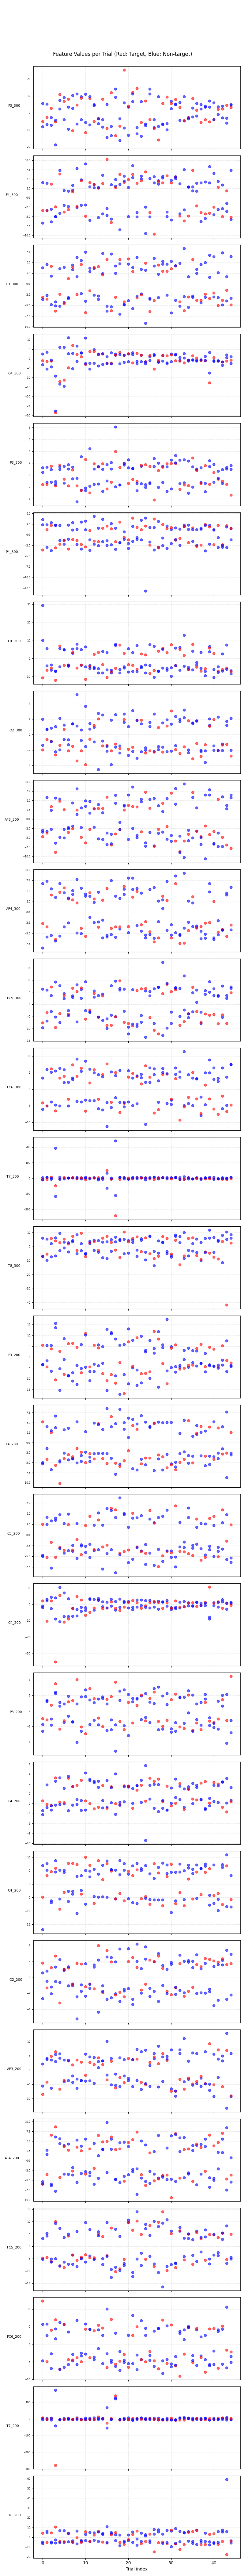

In [20]:
# Generate feature names
timepoints = ['300', '200']
channels = ['F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'AF3', 'AF4', 'FC5', 'FC6', 'T7', 'T8']
n_features = 28
n_trials = 45  # Total number of trials
feature_names = [f"{ch}_{tp}" for tp in timepoints for ch in channels][:n_features]

# Prepare figure
fig, axes = plt.subplots(n_features, 1, figsize=(8, n_features * 3), sharex=True)

for i in range(n_trials):
    trial_X = X[i*3:(i+1)*3]
    trial_y = y[i*3:(i+1)*3]

    for f_idx in range(n_features):
        ax = axes[f_idx]
        for stim_idx in range(3):
            color = 'red' if trial_y[stim_idx] == 1 else 'blue'
            ax.plot(i, trial_X[stim_idx, f_idx], 'o', color=color, alpha=0.6)

# Label y-axes
for f_idx, ax in enumerate(axes):
    ax.set_ylabel(feature_names[f_idx], rotation=0, labelpad=25, fontsize=8)
    ax.tick_params(axis='y', labelsize=6)
    ax.grid(True, linestyle='--', alpha=0.3)

# Final touch
axes[-1].set_xlabel("Trial index")
plt.suptitle("Feature Values per Trial (Red: Target, Blue: Non-target)", fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()
